#### **Week 7 Demo: Offline Policy Evaluation with Doubly Robust Estimation**

**Course:** Causal Machine Learning (GRAD-E1487), Fall 2025  
**Instructor:** Drew Dimmery  
**Presentors:** Aditi, Emilie
**Date:** October 21, 2025  


#### I. Introduction & Motivation  
#### From Effect Estimation to Policy Evaluation  

What we've done so far in this course:

- Estimated treatment effects:  
  $$
  \tau = \mathbb{E}[Y(1) - Y(0)]
  $$

- Estimated conditional treatment effects:  
  $$
  \tau(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]
  $$

- **Goal:** Understand how large effects are (and for whom)



#### Today's shift:

- **Evaluate and learn policies (decision rules)**  
- A policy $\pi: \mathcal{X} \to \{0,1\}$ maps covariates to treatment assignments  
- **Policy value:**  
  $$
  V(\pi) = \mathbb{E}[Y(\pi(X))]
  $$
  expected outcome if we follow $\pi$  
- **Goal:** Find policies that produce good outcomes, not just estimate effects


#### Why This Matters

- Decision-making requires choosing who gets treated (not just knowing effect sizes)  
- Can evaluate policies without estimating $\tau(x)$ for all $x$  



##### II. The Challenge: Off-Policy Evaluation  
### The Contextual Bandit Setting  

**Data structure:**

- Logged data from a behavior policy $\pi_0$: $(X_i, A_i, Y_i)$ for $i = 1, ..., n$  
- Treatments assigned by $\pi_0$: $A_i \sim \pi_0(\cdot \mid X_i)$  
- Partial feedback: Only observe outcome for chosen action: $Y_i = Y_i(A_i)$  


**The goal:**

- Evaluate a target policy $\pi$ without deploying it  
- Estimate:  
  $$
  V(\pi) = \mathbb{E}_X\big[\mathbb{E}[Y(\pi(X)) \mid X]\big]
  $$
- But data came from $\pi_0$, not $\pi$!


#### The Critical Requirement: Overlap  

- **Overlap assumption:** $\pi_0(a \mid x) > 0$ whenever $\pi(a \mid x) > 0$  
- Without overlap: no data to evaluate $\pi$ in some regions of $\mathcal{X}$  


#### III. Three Estimation Approaches

 **1. Direct Method (DM)**

**Strategy:** Model the outcomes  

**Approach:**

Estimate  
$$
\hat{\mu}(a, x) = \mathbb{E}[Y \mid A = a, X = x]
$$

Predict:  
$$
\hat{V}_{DM}(\pi) = \mathbb{E}_X[\hat{\mu}(\pi(X), X)]
$$


**2. Inverse Propensity Score (IPS)**

**Strategy:** Reweight the observations  

**Formula:**  
$$
\hat{V}_{IPS}(\pi) = \frac{1}{n} \sum_i
\left[
\frac{\mathbb{1}(A_i = \pi(X_i))}{\pi_0(A_i \mid X_i)} \cdot Y_i
\right]
$$


**3. Doubly Robust (DR)**

**Strategy:** Combine both approaches  

**Formula:**
$$
\hat{V}_{DR}(\pi)
= \frac{1}{n} \sum_i
\Big[
\hat{\mu}(\pi(X_i), X_i)
+ \frac{\mathbb{1}(A_i = \pi(X_i))}{\pi_0(A_i \mid X_i)} \cdot (Y_i - \hat{\mu}(A_i, X_i))
\Big]
$$


**Intuition:** Outcome model prediction + importance-weighted residual correction  


##### VI. From Evaluation to Learning

**So far:** Evaluate a given policy $\pi$
- Given a candidate policy, estimate its value $V(\pi)$  
- Tells us if a proposed policy is good or bad  

**The learning problem:** Find the best policy from data  


$$
\hat{\pi} \;=\; \arg\max_{\pi \in \Pi} \; \hat{V}_{DR}(\pi)
$$




#### **Demo Structure**

 **Part 1: Data Generation**

- Load a **multiclass classification dataset** (e.g., *digits*, *letter recognition*).  
- Implement the **Dudík transformation**:
  - For each example, sample an action $A_i \sim \pi_0(\cdot \mid X_i)$.
  - Reveal reward $Y_i = \mathbb{1}(A_i = c_i)$.
  - Store the logging probability $\pi_0(A_i \mid X_i)$.  
- Create **logging policies** $\pi_0$ with different exploration levels (*ε*-greedy):
  - Mix deterministic and random behavior using ε ∈ {0.1, 0.3, 0.5}.

 **Part 2: Policy Learning**

- Train an **evaluation policy** $\pi_e$ using supervised learning on the full labels.  
- Evaluate how $\pi_e$ performs under different logging policies $\pi_0$ with varying exploration levels:
  $$
  \varepsilon \in \{0.1, 0.3, 0.5\}
  $$

 **Part 3: Estimation Implementation**

- Implement the **Direct Method (DM)** estimator.  
- Implement the **Inverse Propensity Score (IPS)** estimator.  
- (Later) add the **Doubly Robust (DR)** estimator for comparison.
- Implement **DR estimator**  
- Run **all three estimators** on the same data

 **Part 4: Simulation & Analysis**

- Run 100+ simulation replications  
- Compute for each estimator:

  - **Bias:**  
    $$
    \mathbb{E}[\hat{V}] - V_{\text{true}}
    $$

  - **Variance:**  
    $$
    \operatorname{Var}[\hat{V}]
    $$

  - **MSE:**  
    $$
    \text{Bias}^2 + \text{Variance}
    $$

  



# ADEMP Simulation

## A - AIM
Demonstrate that doubly robust (DR) estimators provide more reliable offline policy evaluation than Direct Method (DM) or Inverse Propensity Scoring (IPS) alone.

**Research Questions:**

- Can we accurately estimate the true policy value \(V(\pi_e)\) using only logged data?  
- How does estimation error change when the reward model is misspecified?  
- How does estimation error change when overlap decreases (poor exploration)?  
- How do DM, IPS, and DR compare in terms of bias, variance, and MSE?


In [37]:
## D - DATA GENERATING PROCESS

# Loading necessary Libraries
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)


In [38]:
### 1. Load UCI Letters Dataset

# Letters dataset has 26 classes (A-Z), 16 features
# Using sklearn's fetch_openml to get the dataset
letters = fetch_openml('letter', version=1, parser='auto')
X = letters.data.values if hasattr(letters.data, 'values') else letters.data
y = letters.target.values if hasattr(letters.target, 'values') else letters.target

# Encode labels to integers 0-25
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(np.unique(y_encoded))

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class distribution:\n{pd.Series(y).value_counts().sort_index()}")

Dataset shape: (20000, 16)
Number of classes: 26
Class distribution:
A    789
B    766
C    736
D    805
E    768
F    775
G    773
H    734
I    755
J    747
K    739
L    761
M    792
N    783
O    753
P    803
Q    783
R    758
S    748
T    796
U    813
V    764
W    752
X    787
Y    786
Z    734
Name: count, dtype: int64


In [39]:
### 2. Train-Test Split (50-50 split as in paper)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Train set size: 14000
Test set size: 6000


In [40]:
### 3. Create Fully Labeled Dataset
# Training data: fully revealed (all losses visible)
train_losses_full = np.zeros((len(X_train), n_classes))
for i, true_class in enumerate(y_train):
    for a in range(n_classes):
        train_losses_full[i, a] = 1 if a != true_class else 0  # 0-1 loss

# Test data: fully revealed (for ground truth computation)
test_losses_full = np.zeros((len(X_test), n_classes))
for i, true_class in enumerate(y_test):
    for a in range(n_classes):
        test_losses_full[i, a] = 1 if a != true_class else 0

print("\nFully labeled data created.")
print(f"Train losses shape: {train_losses_full.shape}")
print(f"Test losses shape: {test_losses_full.shape}")


Fully labeled data created.
Train losses shape: (14000, 26)
Test losses shape: (6000, 26)


In [41]:
### 4. Function to Convert to Bandit Feedback
def create_bandit_data(X, y, losses_full, logging_policy='uniform', epsilon=None):
    """
    Transform fully labeled data into bandit feedback (partially labeled).
    """
    n_samples, n_classes = losses_full.shape
    actions = np.zeros(n_samples, dtype=int)
    propensities = np.zeros(n_samples)
    
    #simulating logging policy for uniform case - for each example randomly selecting one of the 26 letters uniformly
    if logging_policy == 'uniform':
        # Uniform random logging: p(a|x) = 1/k for all a
        actions = np.random.choice(n_classes, size=n_samples)
        propensities = np.ones(n_samples) / n_classes

    #simulating logging policy with epsilon greedy    
    elif logging_policy == 'epsilon_greedy':
        # Epsilon-greedy: with prob epsilon select random, else select true class
        if epsilon is None:
            epsilon = 0.1
        
        for i in range(n_samples):
            if np.random.rand() < epsilon:
                # Explore: random action
                actions[i] = np.random.choice(n_classes)
                propensities[i] = epsilon / n_classes + (1 - epsilon) * (actions[i] == y[i])
            else:
                # Exploit: select true class (deterministic logging policy)
                actions[i] = y[i]
                propensities[i] = epsilon / n_classes + (1 - epsilon)
    
    # Extract observed losses and rewards for selected actions
    # This is creating partial feedback as it is only extracting loss and rewards for the selected action
    losses_observed = losses_full[np.arange(n_samples), actions]
    rewards_observed = 1 - losses_observed  # Convert loss to reward
    
    bandit_data = {
        'contexts': X,
        'actions': actions,
        'rewards': rewards_observed,
        'losses': losses_observed,
        'propensities': propensities,
        'true_labels': y
    }
    
    return bandit_data

# Example: Create bandit feedback with uniform logging policy
print("\n Creating Bandit Feedback (Uniform Logging)")
test_bandit = create_bandit_data(X_test, y_test, test_losses_full, logging_policy='uniform')

print(f"Bandit data created:")
print(f"  - Contexts shape: {test_bandit['contexts'].shape}")
print(f"  - Actions shape: {test_bandit['actions'].shape}")
print(f"  - Propensities (first 5): {test_bandit['propensities'][:5]}")
print(f"  - Average propensity: {test_bandit['propensities'].mean():.4f}")
print(f"\nFirst example:")
print(f"  - True label: {test_bandit['true_labels'][0]}")
print(f"  - Logged action: {test_bandit['actions'][0]}")
print(f"  - Observed loss: {test_bandit['losses'][0]}")
print(f"  - Propensity: {test_bandit['propensities'][0]:.4f}")


 Creating Bandit Feedback (Uniform Logging)
Bandit data created:
  - Contexts shape: (6000, 16)
  - Actions shape: (6000,)
  - Propensities (first 5): [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154]
  - Average propensity: 0.0385

First example:
  - True label: 10
  - Logged action: 6
  - Observed loss: 1.0
  - Propensity: 0.0385


In [42]:
### Step 2: TRAIN THE EVALUATION POLICY π (on training data with full feedback)
policy = LogisticRegression(
    max_iter=1000,        # Number of iterations
    random_state=42,
    solver='lbfgs',       # Solver algorithm
    multi_class='multinomial'  # For multi-class (26 classes)
)
# Train on FULL training data (all losses visible)
policy.fit(X_train, y_train)

# Get predictions on training set
train_predictions = policy.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_error = 1 - train_accuracy

print(f"\nPolicy trained: Logistic Regression")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Training error: {train_error:.4f}")

c:\Users\aditi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Policy trained: Logistic Regression
Training accuracy: 0.7801
Training error: 0.2199


c:\Users\aditi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
#COMPUTE GROUND TRUTH

# This is the TRUE policy value we're trying to estimate
test_predictions = policy.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_error_true = 1 - test_accuracy  # This is V(π) - the ground truth!


print("GROUND TRUTH (what we're trying to estimate)")
print(f"True test accuracy: {test_accuracy:.4f}")
print(f"True test error (V(π)): {test_error_true:.4f}")
print("\n This is the ground truth that we'll compare our estimates against!")

# Save policy predictions for later use
policy_test_predictions = policy.predict(X_test)

GROUND TRUTH (what we're trying to estimate)
True test accuracy: 0.7682
True test error (V(π)): 0.2318

 This is the ground truth that we'll compare our estimates against!


In [44]:

### STEP 4: IMPLEMENT DM, IPS, AND DR ESTIMATORS



### Helper Function: Train Reward Model 

def train_reward_model(bandit_data, X_full, n_classes):
    
    contexts = bandit_data['contexts']
    actions = bandit_data['actions']
    rewards = bandit_data['rewards']
    n_samples = len(contexts)
    n_features = X_full.shape[1]
    
    # Create feature matrix: [context features + one-hot encoded action]
    # For each sample: [x_1, x_2, ..., x_d, I(a=0), I(a=1), ..., I(a=k-1)]
    X_with_actions = np.zeros((n_samples, n_features + n_classes))
    
    for i in range(n_samples):
        # Copy context features
        X_with_actions[i, :n_features] = contexts[i]
        # Add one-hot encoded action
        X_with_actions[i, n_features + actions[i]] = 1
    
    # Train to predict rewards
    reward_model = Ridge(
    alpha=1.0,           # Regularization strength
    random_state=42
    )
    reward_model.fit(X_with_actions, rewards)
    
    return reward_model


def predict_rewards(reward_model, contexts, actions, n_features, n_classes):
    n_samples = len(contexts)
    X_with_actions = np.zeros((n_samples, n_features + n_classes))
    
    for i in range(n_samples):
        # Copy context features
        X_with_actions[i, :n_features] = contexts[i]
        # Add one-hot encoded action
        X_with_actions[i, n_features + actions[i]] = 1
    
    predicted_rewards = reward_model.predict(X_with_actions)
    return predicted_rewards









In [45]:
### ESTIMATOR 1: DIRECT METHOD (DM)

def estimate_dm(bandit_data, policy_actions, reward_model, n_features, n_classes):
    contexts = bandit_data['contexts']
    n_samples = len(contexts)
    
    # Predict rewards for the policy's chosen actions
    predicted_rewards = predict_rewards(
        reward_model, contexts, policy_actions, n_features, n_classes
    )
    
    # DM estimate: average of predicted rewards
    dm_reward_estimate = np.mean(predicted_rewards)
    
    # Convert reward to loss (loss = 1 - reward)
    dm_loss_estimate = 1 - dm_reward_estimate
    
    return dm_loss_estimate



### ESTIMATOR 2: INVERSE PROPENSITY SCORING (IPS)

def estimate_ips(bandit_data, policy_actions):

    actions_logged = bandit_data['actions']      # What was actually done
    rewards = bandit_data['rewards']             # Observed rewards
    propensities = bandit_data['propensities']   # p(a|x) from logging policy
    n_samples = len(actions_logged)
    
    # Indicator: I(logged action = policy action)
    matches = (actions_logged == policy_actions).astype(float)
    
    # Importance weights: I(a_logged = a_policy) / p(a_logged | x)
    importance_weights = matches / propensities
    
    # IPS estimate: weighted average of observed rewards
    weighted_rewards = importance_weights * rewards
    ips_reward_estimate = np.mean(weighted_rewards)
    
    # Convert reward to loss
    ips_loss_estimate = 1 - ips_reward_estimate
    
    return ips_loss_estimate



### ESTIMATOR 3: DOUBLY ROBUST (DR)


def estimate_dr(bandit_data, policy_actions, reward_model, n_features, n_classes):
    
    contexts = bandit_data['contexts']
    actions_logged = bandit_data['actions']
    rewards = bandit_data['rewards']
    propensities = bandit_data['propensities']
    n_samples = len(contexts)
    
    # Part 1: Direct Method component
    # Predict rewards for policy's actions: r̂(x, π(x))
    predicted_rewards_policy = predict_rewards(
        reward_model, contexts, policy_actions, n_features, n_classes
    )
    
    # Part 2: Predict rewards for logged actions: r̂(x, a_logged)
    # This is what the model THINKS the logged action would get
    predicted_rewards_logged = predict_rewards(
        reward_model, contexts, actions_logged, n_features, n_classes
    )
    
    # Part 3: IPS correction term
    # Only apply correction when logged action = policy action
    matches = (actions_logged == policy_actions).astype(float)
    importance_weights = matches / propensities
    
    # Prediction error: (actual - predicted) for the logged action
    prediction_errors = rewards - predicted_rewards_logged
    
    # Correction: re-weight the prediction errors
    correction = importance_weights * prediction_errors
    
    # Part 4: Combine using DR formula
    # DR = Model prediction + Correction for model errors
    dr_rewards = predicted_rewards_policy + correction
    dr_reward_estimate = np.mean(dr_rewards)
    
    # Convert reward to loss
    dr_loss_estimate = 1 - dr_reward_estimate
    
    return dr_loss_estimate



In [46]:
### TEST THE ESTIMATORS (Single Run)

# Create bandit feedback from test set
print("\n Creating bandit feedback with uniform logging policy...")
test_bandit = create_bandit_data(
    X_test, y_test, test_losses_full, 
    logging_policy='uniform'
)
print(f"  Created {len(test_bandit['contexts'])} bandit samples")
print(f"  Logging policy: uniform (p = 1/{n_classes} = {1/n_classes:.4f})")

# Train reward model on bandit data
print("\n2. Training reward model (Random Forest Regressor)...")
reward_model = train_reward_model(test_bandit, X_test, n_classes)
print(f"    Reward model trained on {len(test_bandit['contexts'])} samples")

# Get policy predictions on test contexts
print("\n3. Getting policy predictions...")
policy_test_actions = policy.predict(test_bandit['contexts'])
print(f"    Policy predictions obtained for {len(policy_test_actions)} samples")

# Compute all three estimates

n_features = X_test.shape[1]

dm_estimate = estimate_dm(
    test_bandit, policy_test_actions, reward_model, n_features, n_classes
)


ips_estimate = estimate_ips(test_bandit, policy_test_actions)


dr_estimate = estimate_dr(
    test_bandit, policy_test_actions, reward_model, n_features, n_classes
)


# Display results

print("RESULTS: Single Run Comparison")

print(f"\nGround Truth V(π):        {test_error_true:.4f}")

print(f"Direct Method (DM):       {dm_estimate:.4f}  (error: {dm_estimate - test_error_true:+.4f})")
print(f"IPS:                      {ips_estimate:.4f}  (error: {ips_estimate - test_error_true:+.4f})")
print(f"Doubly Robust (DR):       {dr_estimate:.4f}  (error: {dr_estimate - test_error_true:+.4f})")






 Creating bandit feedback with uniform logging policy...
  Created 6000 bandit samples
  Logging policy: uniform (p = 1/26 = 0.0385)

2. Training reward model (Random Forest Regressor)...
    Reward model trained on 6000 samples

3. Getting policy predictions...
    Policy predictions obtained for 6000 samples
RESULTS: Single Run Comparison

Ground Truth V(π):        0.2318
Direct Method (DM):       0.9580  (error: +0.7261)
IPS:                      0.1593  (error: -0.0725)
Doubly Robust (DR):       0.1685  (error: -0.0633)


**Key Findings**:
- Is that the policy value of the DR is most close to the true policy value. 
- While the IPS comes close to the DR method, the DM method seems to highly overestimate the policy value. What can we learn from this? DM method leads to poor generalization, especially in cases with context-pairs where little to no data exists, likely leading to the overestimation of the policy value that we observe. 

In [47]:

### STEP 5: RUN MULTIPLE SIMULATIONS 

n_simulations = 100
n_features = X_test.shape[1]

# Storage for results
dm_estimates = []
ips_estimates = []
dr_estimates = []

print(f"\nRunning {n_simulations} simulations...")
print("This may take a few minutes...\n")

for sim in range(n_simulations):
    # Progress indicator
    if (sim + 1) % 50 == 0:
        print(f"  Completed {sim + 1}/{n_simulations} simulations...")
    
    # Step 1: Create NEW bandit feedback (different random sample each time)
    bandit_sample = create_bandit_data(
        X_test, y_test, test_losses_full, 
        logging_policy='uniform'
    )
    
    # Step 2: Train reward model on this bandit sample
    reward_model = train_reward_model(bandit_sample, X_test, n_classes)
    
    # Step 3: Get policy predictions
    policy_actions = policy.predict(bandit_sample['contexts'])
    
    # Step 4: Compute all three estimates
    dm_est = estimate_dm(bandit_sample, policy_actions, reward_model, 
                         n_features, n_classes)
    ips_est = estimate_ips(bandit_sample, policy_actions)
    dr_est = estimate_dr(bandit_sample, policy_actions, reward_model, 
                         n_features, n_classes)
    
    # Step 5: Store results
    dm_estimates.append(dm_est)
    ips_estimates.append(ips_est)
    dr_estimates.append(dr_est)

# Convert to numpy arrays
dm_estimates = np.array(dm_estimates)
ips_estimates = np.array(ips_estimates)
dr_estimates = np.array(dr_estimates)

print(f"\n✓ All {n_simulations} simulations completed!\n")




Running 100 simulations...
This may take a few minutes...

  Completed 50/100 simulations...
  Completed 100/100 simulations...

✓ All 100 simulations completed!



In [48]:

### STEP 6: COMPUTE PERFORMANCE METRICS 


# Calculate bias, variance, and RMSE for each estimator
def compute_metrics(estimates, true_value):

    bias = np.mean(estimates) - true_value
    variance = np.var(estimates, ddof=1)  # Sample variance
    rmse = np.sqrt(bias**2 + variance)
    
    return bias, variance, rmse

# Compute metrics for each estimator
dm_bias, dm_var, dm_rmse = compute_metrics(dm_estimates, test_error_true)
ips_bias, ips_var, ips_rmse = compute_metrics(ips_estimates, test_error_true)
dr_bias, dr_var, dr_rmse = compute_metrics(dr_estimates, test_error_true)

# Display results


print(f"{'Estimator':<20} {'Mean':<12} {'Bias':<12} {'Variance':<12} {'RMSE':<12}")

print(f"{'Direct Method':<20} {np.mean(dm_estimates):<12.4f} {dm_bias:<12.4f} {dm_var:<12.6f} {dm_rmse:<12.4f}")
print(f"{'IPS':<20} {np.mean(ips_estimates):<12.4f} {ips_bias:<12.4f} {ips_var:<12.6f} {ips_rmse:<12.4f}")
print(f"{'Doubly Robust':<20} {np.mean(dr_estimates):<12.4f} {dr_bias:<12.4f} {dr_var:<12.6f} {dr_rmse:<12.4f}")




Estimator            Mean         Bias         Variance     RMSE        
Direct Method        0.9617       0.7298       0.000006     0.7298      
IPS                  0.2333       0.0014       0.002569     0.0507      
Doubly Robust        0.2379       0.0061       0.002364     0.0490      


**Key Findings;**
- With the DM method we might have a very precise estimator, but again, this estimator is highly biased.
- While the IPS is slightly less biased, it is also slightly less precise, leading the DR method to achieve best overall performance with lowest RMSE.

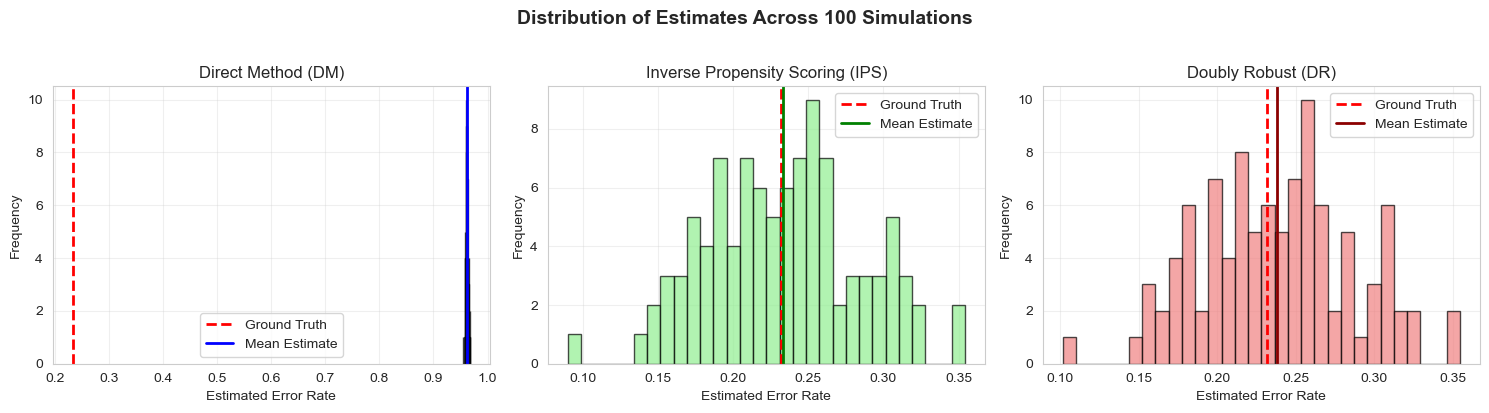

In [49]:

### STEP 7: VISUALIZATIONS

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

### FIGURE 1: Distribution of Estimates (Histograms)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Direct Method
axes[0].hist(dm_estimates, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(test_error_true, color='red', linestyle='--', linewidth=2, label='Ground Truth')
axes[0].axvline(np.mean(dm_estimates), color='blue', linestyle='-', linewidth=2, label='Mean Estimate')
axes[0].set_xlabel('Estimated Error Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Direct Method (DM)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: IPS
axes[1].hist(ips_estimates, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(test_error_true, color='red', linestyle='--', linewidth=2, label='Ground Truth')
axes[1].axvline(np.mean(ips_estimates), color='green', linestyle='-', linewidth=2, label='Mean Estimate')
axes[1].set_xlabel('Estimated Error Rate')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Inverse Propensity Scoring (IPS)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Doubly Robust
axes[2].hist(dr_estimates, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2].axvline(test_error_true, color='red', linestyle='--', linewidth=2, label='Ground Truth')
axes[2].axvline(np.mean(dr_estimates), color='darkred', linestyle='-', linewidth=2, label='Mean Estimate')
axes[2].set_xlabel('Estimated Error Rate')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Doubly Robust (DR)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle(f'Distribution of Estimates Across {n_simulations} Simulations', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()




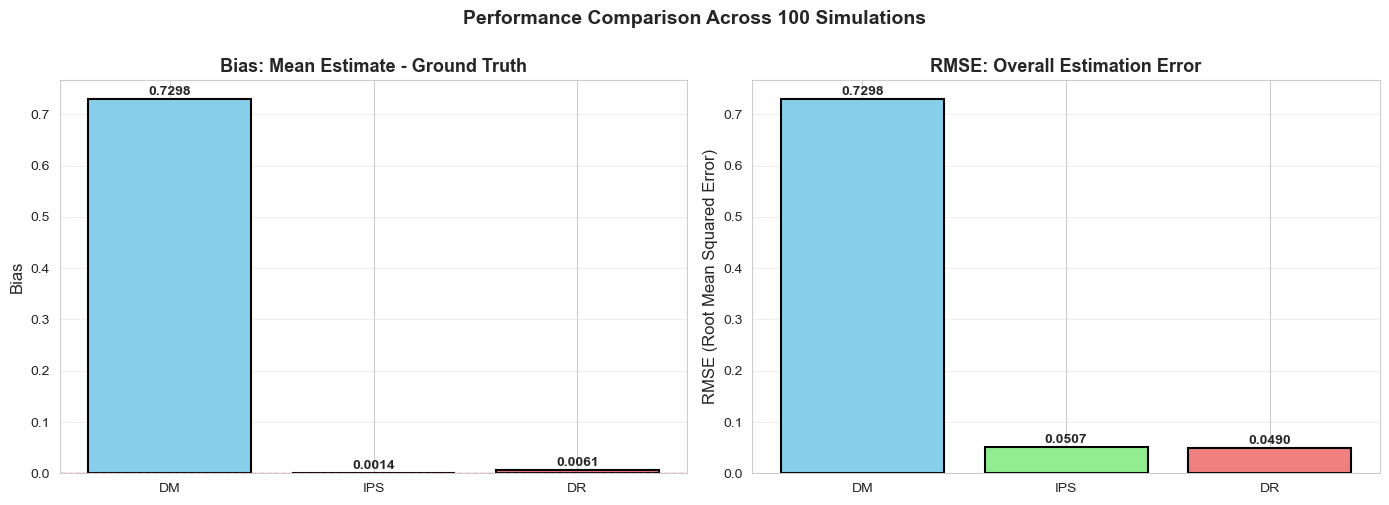

In [50]:
### FIGURE 2: Bias and RMSE Comparison (Bar Charts)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

estimators = ['DM', 'IPS', 'DR']
biases = [dm_bias, ips_bias, dr_bias]
rmses = [dm_rmse, ips_rmse, dr_rmse]
colors = ['skyblue', 'lightgreen', 'lightcoral']

# Plot 1: Bias
axes[0].bar(estimators, biases, color=colors, edgecolor='black', linewidth=1.5)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[0].set_ylabel('Bias', fontsize=12)
axes[0].set_title('Bias: Mean Estimate - Ground Truth', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (est, bias) in enumerate(zip(estimators, biases)):
    axes[0].text(i, bias + 0.002, f'{bias:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: RMSE
axes[1].bar(estimators, rmses, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('RMSE (Root Mean Squared Error)', fontsize=12)
axes[1].set_title('RMSE: Overall Estimation Error', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (est, rmse) in enumerate(zip(estimators, rmses)):
    axes[1].text(i, rmse + 0.002, f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle(f'Performance Comparison Across {n_simulations} Simulations', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()   


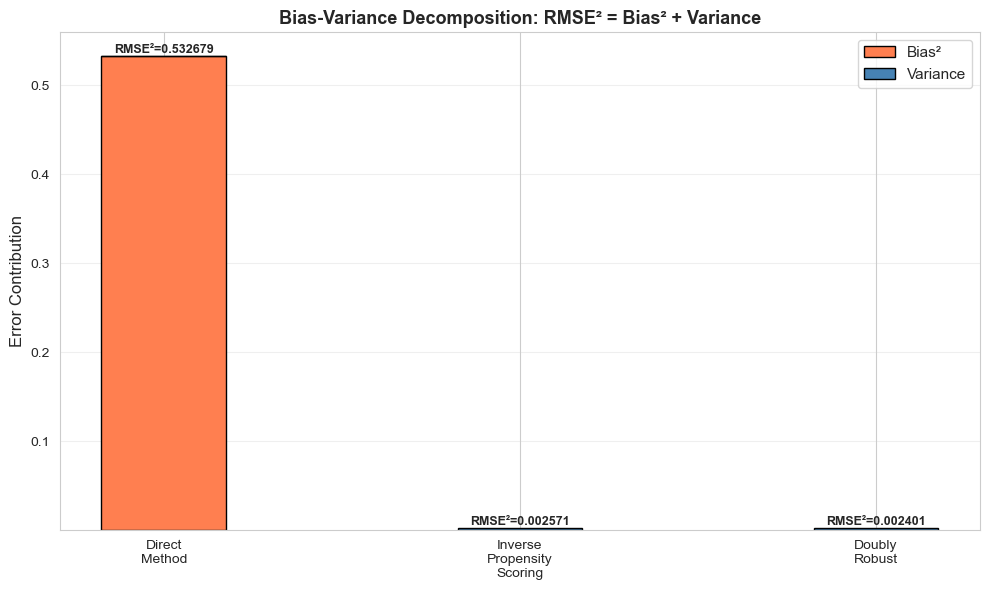

In [51]:
### FIGURE 3: Bias-Variance Decomposition

fig, ax = plt.subplots(figsize=(10, 6))

estimators = ['Direct\nMethod', 'Inverse\nPropensity\nScoring', 'Doubly\nRobust']
biases_squared = [dm_bias**2, ips_bias**2, dr_bias**2]
variances = [dm_var, ips_var, dr_var]

x = np.arange(len(estimators))
width = 0.35

# Stacked bar chart
bars1 = ax.bar(x, biases_squared, width, label='Bias²', color='coral', edgecolor='black')
bars2 = ax.bar(x, variances, width, bottom=biases_squared, label='Variance', 
               color='steelblue', edgecolor='black')

ax.set_ylabel('Error Contribution', fontsize=12)
ax.set_title('Bias-Variance Decomposition: RMSE² = Bias² + Variance', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(estimators)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add RMSE² labels on top
for i, rmse in enumerate([dm_rmse, ips_rmse, dr_rmse]):
    total_height = biases_squared[i] + variances[i]
    ax.text(i, total_height + 0.0002, f'RMSE²={rmse**2:.6f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()   


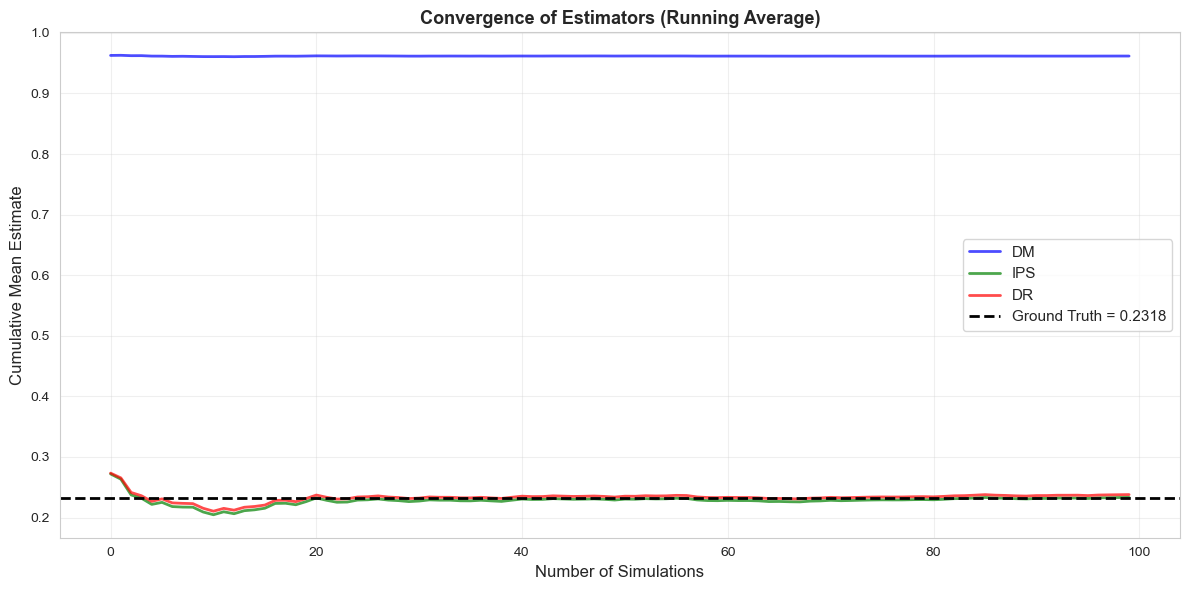

In [52]:
### FIGURE 4: Convergence Plot (Shows estimates over time)

fig, ax = plt.subplots(figsize=(12, 6))

# Calculate cumulative means
dm_cumulative = np.cumsum(dm_estimates) / np.arange(1, len(dm_estimates) + 1)
ips_cumulative = np.cumsum(ips_estimates) / np.arange(1, len(ips_estimates) + 1)
dr_cumulative = np.cumsum(dr_estimates) / np.arange(1, len(dr_estimates) + 1)

# Plot cumulative means
ax.plot(dm_cumulative, label='DM', color='blue', linewidth=2, alpha=0.7)
ax.plot(ips_cumulative, label='IPS', color='green', linewidth=2, alpha=0.7)
ax.plot(dr_cumulative, label='DR', color='red', linewidth=2, alpha=0.7)

# Ground truth reference line
ax.axhline(test_error_true, color='black', linestyle='--', linewidth=2, 
           label=f'Ground Truth = {test_error_true:.4f}')

ax.set_xlabel('Number of Simulations', fontsize=12)
ax.set_ylabel('Cumulative Mean Estimate', fontsize=12)
ax.set_title('Convergence of Estimators (Running Average)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()  


**Key Findings:**
- DM does not converge to the truth.
- IPS and DR are consistent; i.e., they do converge to the truth over simulations.

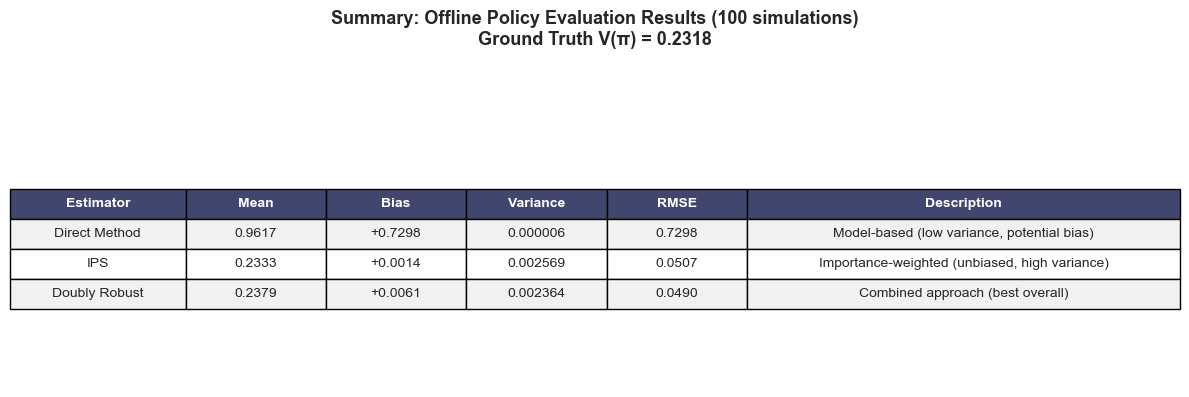

In [53]:
### FIGURE 5: Summary Table 

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Create summary table
table_data = [
    ['Estimator', 'Mean', 'Bias', 'Variance', 'RMSE', 'Description'],
    ['Direct Method', f'{np.mean(dm_estimates):.4f}', f'{dm_bias:+.4f}', 
     f'{dm_var:.6f}', f'{dm_rmse:.4f}', 'Model-based (low variance, potential bias)'],
    ['IPS', f'{np.mean(ips_estimates):.4f}', f'{ips_bias:+.4f}', 
     f'{ips_var:.6f}', f'{ips_rmse:.4f}', 'Importance-weighted (unbiased, high variance)'],
    ['Doubly Robust', f'{np.mean(dr_estimates):.4f}', f'{dr_bias:+.4f}', 
     f'{dr_var:.6f}', f'{dr_rmse:.4f}', 'Combined approach (best overall)']
]

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.15, 0.12, 0.12, 0.12, 0.12, 0.37])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(6):
    cell = table[(0, i)]
    cell.set_facecolor('#40466e')
    cell.set_text_props(weight='bold', color='white')

# Style data rows with alternating colors
colors_row = ['#f1f1f2', '#ffffff', '#f1f1f2']
for i in range(1, 4):
    for j in range(6):
        cell = table[(i, j)]
        cell.set_facecolor(colors_row[i-1])

plt.suptitle(
    f'Summary: Offline Policy Evaluation Results ({n_simulations} simulations)\n'
    f'Ground Truth V(π) = {test_error_true:.4f}',
    fontsize=13, fontweight='bold', y=0.98
)

# No saving — show only
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [54]:
## Experiment with Different Epsilon Values

def run_epsilon_experiment(epsilon_values, n_simulations=100):
    
    results = {
        'epsilon': [],
        'dm_bias': [], 'dm_var': [], 'dm_rmse': [],
        'ips_bias': [], 'ips_var': [], 'ips_rmse': [],
        'dr_bias': [], 'dr_var': [], 'dr_rmse': []
    }
    
    n_features = X_test.shape[1]
    
    for eps in epsilon_values:
        
        print(f"Testing ε = {eps:.2f} ({n_simulations} simulations)")
        
        
        dm_estimates = []
        ips_estimates = []
        dr_estimates = []
        
        for sim in range(n_simulations):
            if (sim + 1) % 25 == 0:
                print(f"  Progress: {sim + 1}/{n_simulations}...", end='\r')
            
            # Create bandit feedback with epsilon-greedy logging
            bandit_sample = create_bandit_data(
                X_test, y_test, test_losses_full,
                logging_policy='epsilon_greedy',
                epsilon=eps
            )
            
            # Train reward model
            reward_model = train_reward_model(bandit_sample, X_test, n_classes)
            
            # Get policy predictions
            policy_actions = policy.predict(bandit_sample['contexts'])
            
            # Compute estimates
            dm_est = estimate_dm(bandit_sample, policy_actions, reward_model,
                               n_features, n_classes)
            ips_est = estimate_ips(bandit_sample, policy_actions)
            dr_est = estimate_dr(bandit_sample, policy_actions, reward_model,
                               n_features, n_classes)
            
            dm_estimates.append(dm_est)
            ips_estimates.append(ips_est)
            dr_estimates.append(dr_est)
        
        # Convert to arrays
        dm_estimates = np.array(dm_estimates)
        ips_estimates = np.array(ips_estimates)
        dr_estimates = np.array(dr_estimates)
        
        # Compute metrics
        dm_bias, dm_var, dm_rmse = compute_metrics(dm_estimates, test_error_true)
        ips_bias, ips_var, ips_rmse = compute_metrics(ips_estimates, test_error_true)
        dr_bias, dr_var, dr_rmse = compute_metrics(dr_estimates, test_error_true)
        
        # Store results
        results['epsilon'].append(eps)
        results['dm_bias'].append(dm_bias)
        results['dm_var'].append(dm_var)
        results['dm_rmse'].append(dm_rmse)
        results['ips_bias'].append(ips_bias)
        results['ips_var'].append(ips_var)
        results['ips_rmse'].append(ips_rmse)
        results['dr_bias'].append(dr_bias)
        results['dr_var'].append(dr_var)
        results['dr_rmse'].append(dr_rmse)
        
        print(f"\n  ✓ Completed ε = {eps:.2f}")
        print(f"    IPS Variance: {ips_var:.6f}")
        print(f"    DR RMSE: {dr_rmse:.4f}")
    
    return results



In [55]:
# TODO: STUDENTS CAN MODIFY THESE VALUES!
epsilon_values_to_test = [0.0, 0.1, 0.3, 0.5, 0.7, 1.0]  # try for 0.1, 0.3, 0.5, 0.7, 1.0
n_sims = 100  # Reduce for faster testing, you can try for 200, 400, 500 etc
results = run_epsilon_experiment(epsilon_values_to_test, n_simulations=n_sims)


Testing ε = 0.00 (100 simulations)
  Progress: 100/100...
  ✓ Completed ε = 0.00
    IPS Variance: 0.000000
    DR RMSE: 0.2318
Testing ε = 0.10 (100 simulations)
  Progress: 100/100...
  ✓ Completed ε = 0.10
    IPS Variance: 0.000010
    DR RMSE: 0.0839
Testing ε = 0.30 (100 simulations)
  Progress: 100/100...
  ✓ Completed ε = 0.30
    IPS Variance: 0.000055
    DR RMSE: 0.0396
Testing ε = 0.50 (100 simulations)
  Progress: 100/100...
  ✓ Completed ε = 0.50
    IPS Variance: 0.000138
    DR RMSE: 0.0244
Testing ε = 0.70 (100 simulations)
  Progress: 100/100...
  ✓ Completed ε = 0.70
    IPS Variance: 0.000269
    DR RMSE: 0.0167
Testing ε = 1.00 (100 simulations)
  Progress: 100/100...
  ✓ Completed ε = 1.00
    IPS Variance: 0.003918
    DR RMSE: 0.0603


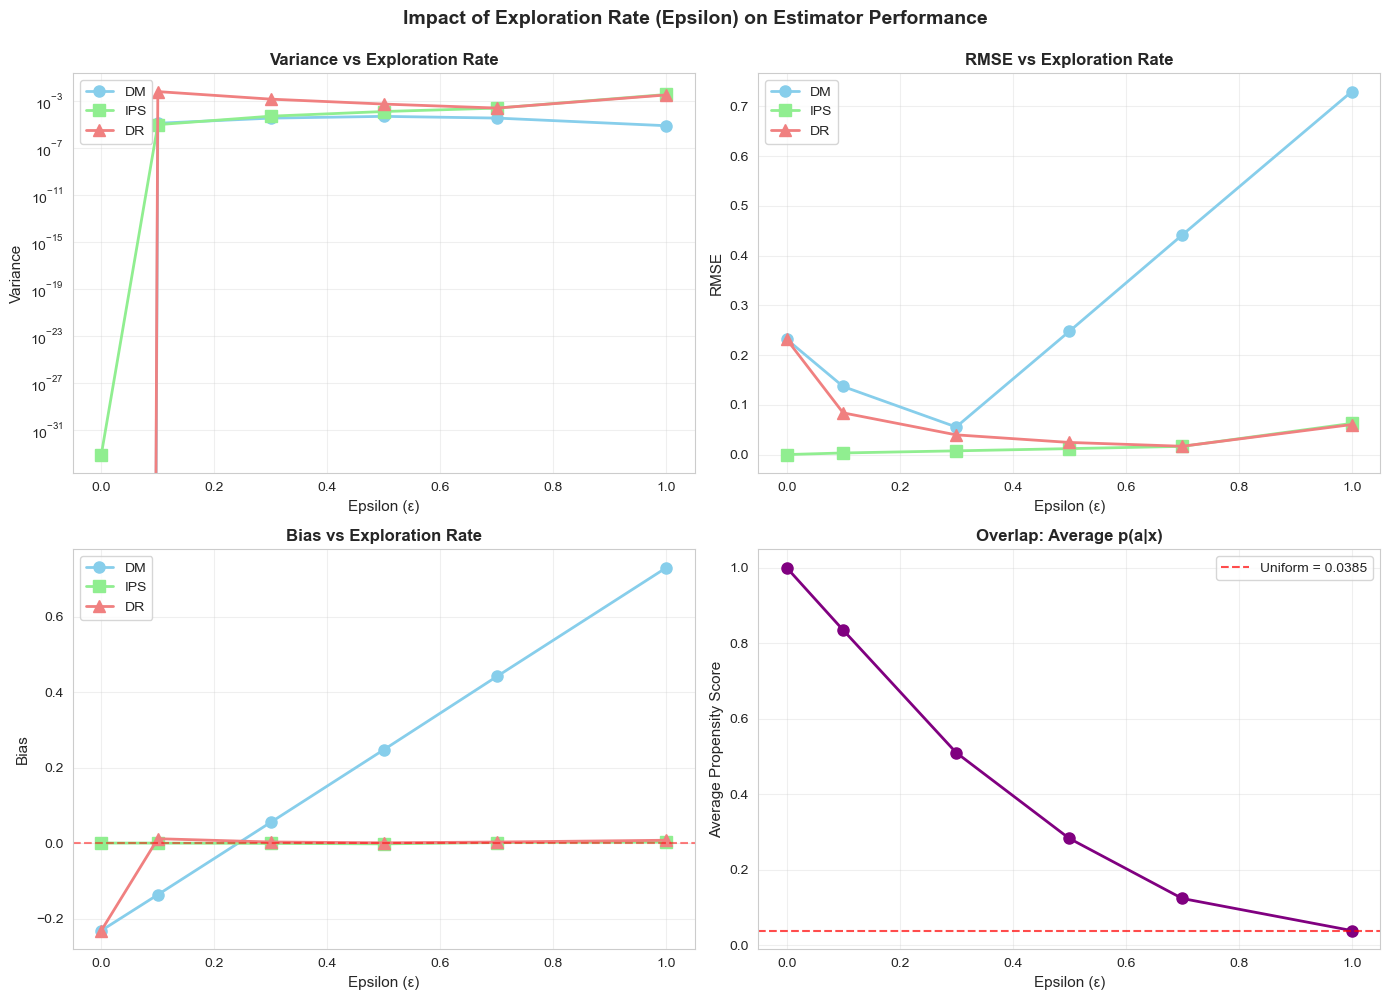

In [56]:
### TASK 2: Visualize Results
# EXPERIMENT:
# Change epsilon values to see how overlap affects DM, IPS, and DR estimators.

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Variance vs Epsilon
axes[0, 0].plot(results['epsilon'], results['dm_var'], 'o-', 
                label='DM', linewidth=2, markersize=8, color='skyblue')
axes[0, 0].plot(results['epsilon'], results['ips_var'], 's-', 
                label='IPS', linewidth=2, markersize=8, color='lightgreen')
axes[0, 0].plot(results['epsilon'], results['dr_var'], '^-', 
                label='DR', linewidth=2, markersize=8, color='lightcoral')
axes[0, 0].set_xlabel('Epsilon (ε)', fontsize=11)
axes[0, 0].set_ylabel('Variance', fontsize=11)
axes[0, 0].set_title('Variance vs Exploration Rate', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')  # Log scale to see differences better

# Plot 2: RMSE vs Epsilon
axes[0, 1].plot(results['epsilon'], results['dm_rmse'], 'o-', 
                label='DM', linewidth=2, markersize=8, color='skyblue')
axes[0, 1].plot(results['epsilon'], results['ips_rmse'], 's-', 
                label='IPS', linewidth=2, markersize=8, color='lightgreen')
axes[0, 1].plot(results['epsilon'], results['dr_rmse'], '^-', 
                label='DR', linewidth=2, markersize=8, color='lightcoral')
axes[0, 1].set_xlabel('Epsilon (ε)', fontsize=11)
axes[0, 1].set_ylabel('RMSE', fontsize=11)
axes[0, 1].set_title('RMSE vs Exploration Rate', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Bias vs Epsilon
axes[1, 0].plot(results['epsilon'], results['dm_bias'], 'o-', 
                label='DM', linewidth=2, markersize=8, color='skyblue')
axes[1, 0].plot(results['epsilon'], results['ips_bias'], 's-', 
                label='IPS', linewidth=2, markersize=8, color='lightgreen')
axes[1, 0].plot(results['epsilon'], results['dr_bias'], '^-', 
                label='DR', linewidth=2, markersize=8, color='lightcoral')
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Epsilon (ε)', fontsize=11)
axes[1, 0].set_ylabel('Bias', fontsize=11)
axes[1, 0].set_title('Bias vs Exploration Rate', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Average Propensity Score vs Epsilon
avg_propensities = []
for eps in results['epsilon']:
    sample = create_bandit_data(
        X_test[:1000], y_test[:1000], test_losses_full[:1000],
        logging_policy='epsilon_greedy', epsilon=eps
    )
    avg_propensities.append(np.mean(sample['propensities']))

axes[1, 1].plot(results['epsilon'], avg_propensities, 'o-', 
                linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Epsilon (ε)', fontsize=11)
axes[1, 1].set_ylabel('Average Propensity Score', fontsize=11)
axes[1, 1].set_title('Overlap: Average p(a|x)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(1/n_classes, color='red', linestyle='--', 
                   label=f'Uniform = {1/n_classes:.4f}', alpha=0.7)
axes[1, 1].legend(fontsize=10)

plt.suptitle('Impact of Exploration Rate (Epsilon) on Estimator Performance', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()   


**Key Findings:**
- DM is not stable with increasing ε, with RMSE increasing linearly from ε=0.3 onwards.
- DM method is highly sensitive to the exploration rate, where bias is positive and linearly related to the values of the epsilon.
- IPS has high variance at low overlap.
- DR is the most robust estimator.

Now, we move on to a new (simulated) dataset: Website visitations from ads.

In [57]:
# Tasks to run 


# Data Generation 
def generate_ad_data(n=5000, seed=42, epsilon=0.3):
    """Generate synthetic ad campaign data"""
    np.random.seed(seed)
    
    age = np.random.normal(35, 12, n)
    income = np.random.gamma(shape=2, scale=30000, size=n)
    time_on_site = np.random.exponential(scale=5, size=n)
    previous_purchases = np.random.poisson(lam=2, size=n)
    engagement_score = np.random.beta(2, 5, n) * 100
    
    propensity_score = epsilon + (1 - epsilon) * (engagement_score > 50).astype(float)
    treatment = np.random.binomial(1, propensity_score)
    optimal_treatment = ((income > 50000) & (engagement_score > 60)).astype(int)
    
    base_value = (0.5 * (age - 35) + 0.001 * income + 2 * time_on_site + 
                  5 * previous_purchases + 0.3 * engagement_score + 
                  np.random.normal(0, 10, n))
    
    treatment_effect = (20 * (income > 50000) + 15 * (engagement_score > 60) + 
                       -10 * (age < 25) + np.random.normal(0, 5, n))
    
    Y = np.maximum(base_value + treatment * treatment_effect, 0)
    
    df = pd.DataFrame({
        'age': age, 'income': income, 'time_on_site': time_on_site,
        'previous_purchases': previous_purchases, 'engagement_score': engagement_score,
        'treatment': treatment, 'propensity_score': propensity_score,
        'outcome': Y, 'optimal_treatment': optimal_treatment
    })
    
    return df

# Quick view of generated data
sample_df = generate_ad_data(n=100, seed=42, epsilon=0.3)
print(sample_df.head(20))


class DirectMethodEstimator:
    """Direct Method: Learn E[Y|X,A], then optimize policy"""
    
    def __init__(self, model=None):
        if model is None:
            self.model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
        else:
            self.model = model
        self.feature_cols = ['age', 'income', 'time_on_site', 'previous_purchases', 'engagement_score']
    
    def fit(self, df):
        X = df[self.feature_cols].reset_index(drop=True)
        X_with_treatment = pd.concat([X, pd.Series(df['treatment'].values, name='treatment')], axis=1)
        self.model.fit(X_with_treatment, df['outcome'].values)
    
    def predict_policy(self, df):
        X = df[self.feature_cols].reset_index(drop=True)
        X_treat_0 = pd.concat([X, pd.Series(0, index=X.index, name='treatment')], axis=1)
        X_treat_1 = pd.concat([X, pd.Series(1, index=X.index, name='treatment')], axis=1)
        y_pred_0 = self.model.predict(X_treat_0)
        y_pred_1 = self.model.predict(X_treat_1)
        return (y_pred_1 > y_pred_0).astype(int)
    
    def estimate_value(self, df):
        policy = self.predict_policy(df)
        X = df[self.feature_cols].reset_index(drop=True)
        X_with_policy = pd.concat([X, pd.Series(policy, index=X.index, name='treatment')], axis=1)
        return self.model.predict(X_with_policy).mean()


class IPWEstimator:
    """Inverse Propensity Weighting: Reweight observations"""
    
    def __init__(self, policy_model=None):
        if policy_model is None:
            self.policy_model = LogisticRegression(max_iter=500)
        else:
            self.policy_model = policy_model
        self.feature_cols = ['age', 'income', 'time_on_site', 'previous_purchases', 'engagement_score']
    
    def fit(self, df):
        X = df[self.feature_cols].reset_index(drop=True)
        weights = np.where(df['treatment'].values == 1, 
                          df['outcome'].values / df['propensity_score'].values,
                          df['outcome'].values / (1 - df['propensity_score'].values))
        self.policy_model.fit(X, df['treatment'].values, sample_weight=np.abs(weights))
    
    def predict_policy(self, df):
        X = df[self.feature_cols].reset_index(drop=True)
        return self.policy_model.predict(X)
    
    def estimate_value(self, df):
        policy = self.predict_policy(df)
        weights = np.where(df['treatment'].values == policy,
                          1 / np.where(df['treatment'].values == 1, df['propensity_score'].values, 
                                      1 - df['propensity_score'].values), 0)
        return (weights * df['outcome'].values).sum() / len(df)


class DoublyRobustEstimator:
    """Doubly Robust: Combines DM and IPW"""
    
    def __init__(self, outcome_model=None, policy_model=None):
        if outcome_model is None:
            self.outcome_model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
        else:
            self.outcome_model = outcome_model
        if policy_model is None:
            self.policy_model = LogisticRegression(max_iter=500)
        else:
            self.policy_model = policy_model
        self.feature_cols = ['age', 'income', 'time_on_site', 'previous_purchases', 'engagement_score']
    
    def fit(self, df):
        X = df[self.feature_cols].reset_index(drop=True)
        X_with_treatment = pd.concat([X, pd.Series(df['treatment'].values, name='treatment')], axis=1)
        self.outcome_model.fit(X_with_treatment, df['outcome'].values)
        self.policy_model.fit(X, df['treatment'].values)
    
    def predict_policy(self, df):
        X = df[self.feature_cols].reset_index(drop=True)
        X_treat_0 = pd.concat([X, pd.Series(0, index=X.index, name='treatment')], axis=1)
        X_treat_1 = pd.concat([X, pd.Series(1, index=X.index, name='treatment')], axis=1)
        y_pred_0 = self.outcome_model.predict(X_treat_0)
        y_pred_1 = self.outcome_model.predict(X_treat_1)
        return (y_pred_1 > y_pred_0).astype(int)
    
    def estimate_value(self, df):
        policy = self.predict_policy(df)
        X = df[self.feature_cols].reset_index(drop=True)
        X_with_policy = pd.concat([X, pd.Series(policy, index=X.index, name='treatment')], axis=1)
        y_pred = self.outcome_model.predict(X_with_policy)
        
        weights = np.where(df['treatment'].values == policy,
                          1 / np.where(df['treatment'].values == 1, df['propensity_score'].values, 
                                      1 - df['propensity_score'].values), 0)
        return (y_pred + weights * (df['outcome'].values - y_pred)).mean()


def run_experiment(data_fn, n, reps, n_estimators=50, methods=['DM', 'IPW', 'DR']):
    """Run experiment comparing policy learning methods"""
    results = []
    oracle_values = []
    
    for rep in range(reps):
        df = data_fn(n=n, seed=42 + rep)
        train_df, test_df = train_test_split(df, test_size=0.3, random_state=rep)
        
        estimators = {}
        if 'DM' in methods:
            estimators['DM'] = DirectMethodEstimator(
                model=RandomForestRegressor(n_estimators=n_estimators, max_depth=3, random_state=rep)
            )
        if 'IPW' in methods:
            estimators['IPW'] = IPWEstimator()
        if 'DR' in methods:
            estimators['DR'] = DoublyRobustEstimator(
                outcome_model=RandomForestRegressor(n_estimators=n_estimators, max_depth=3, random_state=rep)
            )
        
        for name, estimator in estimators.items():
            estimator.fit(train_df)
            value = estimator.estimate_value(test_df)
            results.append({'Method': name, 'Rep': rep, 'Value': value})
        
        optimal_policy = test_df['optimal_treatment'].values
        X = test_df[['age', 'income', 'time_on_site', 'previous_purchases', 'engagement_score']].reset_index(drop=True)
        X_with_opt = pd.concat([X, pd.Series(optimal_policy, name='treatment')], axis=1)
        dm_temp = DirectMethodEstimator(model=RandomForestRegressor(n_estimators=50, random_state=rep))
        dm_temp.fit(df)
        oracle_values.append(dm_temp.model.predict(X_with_opt).mean())
    
    results_df = pd.DataFrame(results)
    oracle_mean = np.mean(oracle_values)
    
    summary = results_df.groupby('Method')['Value'].agg(['mean', 'std', 'var']).reset_index()
    summary['Bias_sq'] = (summary['mean'] - oracle_mean) ** 2
    summary['Oracle'] = oracle_mean
    summary.columns = ['Method', 'Mean_Value', 'Std_Dev', 'Variance', 'Bias_sq', 'Oracle']
    
    return summary

print(" Functions and classes loaded successfully!")
print("Ready to run experiments")



          age         income  time_on_site  previous_purchases  \
0   40.960570   12775.367229      2.346920                   1   
1   33.340828   35413.842408      4.915625                   4   
2   42.772262   44009.951111      3.497197                   1   
3   53.276358   67338.166261      9.706747                   1   
4   32.190160   60652.909246      5.374874                   0   
5   32.190357   47171.788920      0.889264                   0   
6   53.950554    6423.152457      0.365912                   4   
7   44.209217   48980.135834      5.141971                   2   
8   29.366307   52369.170834      0.134345                   1   
9   41.510721  218939.933663      4.406737                   1   
10  29.438988   42913.793179     14.086277                   3   
11  29.411243   62611.785674      4.283912                   4   
12  37.903547  108606.382766      2.456503                   4   
13  12.040637   85142.180894      5.154136                   3   
14  14.300

In [ ]:
#  TASK 1 - BASELINE COMPARISON
#  INSTRUCTIONS: Run this cell as-is to see baseline results
# No modifications needed!

print("   • Sample size: 5000")
print("   • Exploration rate: 0.3") 
print("   • Model complexity: 50 trees\n")

results_task1 = run_experiment(
    data_fn=lambda n, seed: generate_ad_data(n=n, seed=seed, epsilon=0.3),
    n=5000,
    reps=10
)

print("\nRESULTS:")
print(results_task1.to_string(index=False))



# WHAT TO OBSERVE:
print("• Mean_Value: How close is each method to Policy Value?")
print("• Bias_sq: Which method is most accurate on average?")
print("• Variance: Which method is most stable across runs?")
print("• DR should show: Moderate bias, moderate variance (balanced!)")



# Which method gets closest to the Policy value?")
# Does any method have both low bias AND low variance?")
# What's the tradeoff between DM and IPW?")




In [ ]:
#  TASK 2 - EXPLORATION RATE SENSITIVITY

#  INSTRUCTIONS: 
# 1. Run this cell with epsilon=0.1
# 2. Observe the results (especially IPW variance!)
# 3. Change epsilon to 0.5 and re-run
# 4. Compare the two results

# MODIFY THIS PARAMETER:
epsilon_to_test = 0.5  # Try: 0.1, 0.3, 0.5


print(f"\n Testing with exploration rate = {epsilon_to_test}")
print(f"   • epsilon={epsilon_to_test} means {epsilon_to_test*100:.0f}% random, {(1-epsilon_to_test)*100:.0f}% targeted")
print(f"   • Sample size: 5000")
print(f"   • Model complexity: 50 trees\n")

results_task2 = run_experiment(
    data_fn=lambda n, seed: generate_ad_data(n=n, seed=seed, epsilon=epsilon_to_test),
    n=5000,
    reps=10
)

print("\n RESULTS:")
print(results_task2.to_string(index=False))

# What to observe
# if epsilon_to_test < 0.2: 
   
# if epsilon_to_test > 0.4:
    


In [ ]:
#TASK 3 - MODEL COMPLEXITY SENSITIVITY
# INSTRUCTIONS:
# 1. Run this cell with n_estimators=10 (simple model)
# 2. Observe DM's high bias
# 3. Change to n_estimators=200 (complex model) and re-run
# 4. Compare how DM and DR are affected

#  MODIFY THIS PARAMETER:
n_estimators_to_test = 200  # Try: 10, 50, 200


print(f"\n Testing with {n_estimators_to_test} trees in Random Forest")
print(f"   • Sample size: 5000")
print(f"   • Exploration rate: 0.3\n")

results_task3 = run_experiment(
    data_fn=lambda n, seed: generate_ad_data(n=n, seed=seed, epsilon=0.3),  # we recommend to modify these values as well
    n=5000,
    reps=10,
    n_estimators=n_estimators_to_test
)

print(results_task3.to_string(index=False))

# What to tobserve
# n_estimators=10:  DM Bias_sq will be HIGH (100-500)
#                   Why? Can't capture treatment heterogeneity
# n_estimators=200: DM Bias_sq will be LOW (10-50)
#                   Why? Complex model captures patterns



In [ ]:
#  TASK 4 - SAMPLE SIZE SENSITIVITY
# INSTRUCTIONS:
# 1. Run this cell with n=1000 (small sample)
# 2. Observe high variance for ALL methods
# 3. Change to n=10000 (large sample) and re-run
# 4. See how variance shrinks for everyone

# MODIFY THIS PARAMETER:
n_to_test = 10000  # Try: 1000, 5000, 10000


results_task4 = run_experiment(
    data_fn=lambda n, seed: generate_ad_data(n=n, seed=seed, epsilon=0.3),
    n=n_to_test,
    reps=10
)

print("\n RESULTS:")
print(results_task4.to_string(index=False))





**Key take-aways from exercise:**
- With poor overlap:
    -  Variance in IPW explodes; DR inherits this instability
    -  DM extrapolates and bias increases
- With better overlap:
    -  Variance in DM changes little
    -  IPS stabilizes and DR improves and gets closer to the oracle
- With more estimators:
    -  DM/DR improve up to a certain point, then they risk overfitting
- With higher sample size: 
    -  Variance decreases for all methods as it is negatively related to sample size
    -  Bias does not disappear if propensities are extreme or if model is misspecified

**Suggestions for students as they move forward:**
- For now, we have done **policy evaluation**. On your own, you can try doing policy optimization. Dudik et al. (2011) recommend the following steps for **policy optimization**:
    - **Step 1**: Split dataset into training and test split
    - **Step 2**: Construct a partially labelled dataset; i.e., the bandit data that we created above
    - **Steo 3**: Use DR and IPS to impute revealed losses
    - **Step 4**: Train cost-sensitive multiclass classification algorithms for IPS and DR (see Dudik et al., 2011 for my info)
    - **Step 5**: Evaluate learned classifiers on test set and obtain classification error. 
- UCI has many different datasets for classifications. In Dudik et al., they used many more with varying n.

## Source:
- Dudik,M., Langford, J., & Li, L. (2011). "Doubly Robust Policy Evaluation and Learning." In *International Conference on Machine Learning,* 1049-1104. PMLR
- https://github.com/banditml/offline-policy-evaluation 
- chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://bcirwis2021.github.io/Evaluating.pdf 
